In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pyodbc
from datetime import datetime
print(pyodbc.drivers())
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
from scipy import stats
import random
random.seed(42)

['SQL Server', 'ODBC Driver 17 for SQL Server', 'SQL Server Native Client RDA 11.0', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']


In [8]:
def create_sql_connection(server, database, username, password, driver='{ODBC Driver 17 for SQL Server}'):
    """
    Establish a connection to a SQL Server database using pyodbc.

    Parameters:
    - server (str): The SQL Server address (e.g., 'localhost' or server IP).
    - database (str): The name of the database you want to connect to.
    - username (str): SQL Server username.
    - password (str): SQL Server password.
    - driver (str): ODBC driver to use. Default is '{ODBC Driver 17 for SQL Server}'.s

    Returns:
    - conn: A pyodbc connection object if successful.
    """
    connection_string = f"""
        DRIVER={driver};
        SERVER={server};
        DATABASE={database};
        UID={username};
        PWD={password};
    """
    try:
        conn = pyodbc.connect(connection_string)
        print("Connection established successfully!")
        return conn
    except Exception as e:
        print(f"Failed to connect to the database. Error: {e}")
        return None

In [9]:
def query_data(conn, query):
    """
    Execute a SQL query and fetch results as a pandas DataFrame.
    
    Parameters:
    - conn: A pyodbc connection object.
    - query (str): The SQL query to be executed.
    
    Returns:
    - data: A pandas DataFrame containing the query result.
    """
    start_time = time.time()  # Start time measurement
    try:
        cursor = conn.cursor()
        cursor.execute(query)
        
        # Fetch all results from the query
        rows = cursor.fetchall()
        
        # Get column names from cursor
        columns = [desc[0] for desc in cursor.description]
        
        # Create a pandas DataFrame from the results
        data = pd.DataFrame.from_records(rows, columns=columns)
        
    except pyodbc.Error as e:
        print(f"Error executing query: {e}")
        return None
    
    finally:
        cursor.close()
    
    end_time = time.time()  # End time measurement
    execution_time = end_time - start_time  # Calculate execution time
    
    # Print the DataFrame and execution time
    print(f"Query executed in: {execution_time:.4f} seconds")
    
    return data  

In [13]:
server = 'nbfi-loan-def-prediction.database.windows.net'     
database = 'NBFIDB'  
username = 'adminuser'       
password = 'Rambo@12345' 

# Establish connection
conn = create_sql_connection(server, database, username, password)

Connection established successfully!


### Loading data

In [15]:
query = """
select * from bronze.CustomerRaw
"""

In [16]:
data_temp = query_data(conn, query)
data_temp.shape

Query executed in: 0.2633 seconds


(0, 40)

In [21]:
data = pd.read_csv(r'../data/NBFIData.csv')

In [22]:
data.head()

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Client_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Defaulters
0,12142509,6750.0,0.0,0.0,1.0,0.0,0.0,61190.55,3416.85,Alone,Commercial,Secondary,M,Male,CL,Home,0.028663,13957.0,1062.0,6123.0,383.0,NaN,1,1,0,Sales,2.0,2.0,6.0,17.0,Yes,Yes,Self-employed,0.568066,0.478787,NaN,0.0186,63.0,NaN,0
1,12138936,20250.0,1.0,0.0,1.0,NaN,0.0,15282.00,1826.55,Alone,Service,Graduation,M,Male,CL,Home,0.008575,14162.0,4129.0,7833.0,21.0,0.0,1,0,1,NaN,2.0,2.0,3.0,10.0,Yes,Yes,Government,0.563360,0.215068,NaN,NaN,NaN,NaN,0
2,12181264,18000.0,0.0,0.0,1.0,0.0,1.0,59527.35,2788.20,Alone,Service,Graduation dropout,W,Male,CL,Family,0.022800,16790.0,5102.0,NaN,331.0,NaN,1,0,0,Realty agents,2.0,2.0,4.0,NaN,Yes,Yes,Self-employed,NaN,0.552795,0.329655,0.0742,277.0,0.0,0
3,12188929,15750.0,0.0,0.0,1.0,1.0,0.0,53870.40,2295.45,Alone,Retired,Secondary,M,Male,CL,Home,0.010556,23195.0,365243.0,NaN,775.0,NaN,1,0,0,NaN,2.0,3.0,2.0,15.0,Yes,Yes,XNA,NaN,0.135182,0.631355,NaN,1700.0,3.0,0
4,12133385,33750.0,1.0,0.0,1.0,0.0,2.0,133988.40,3547.35,Alone,Commercial,Secondary,M,Female,CL,Home,0.020713,11366.0,2977.0,5516.0,4043.0,6.0,1,0,0,Laborers,4.0,1.0,3.0,NaN,Yes,Yes,Business Entity Type 3,0.508199,0.301182,0.355639,0.2021,674.0,1.0,0


In [23]:
data.dtypes

ID                              int64
Client_Income                 float64
Car_Owned                     float64
Bike_Owned                    float64
Active_Loan                   float64
House_Own                     float64
Child_Count                   float64
Credit_Amount                 float64
Loan_Annuity                  float64
Accompany_Client               object
Client_Income_Type             object
Client_Education               object
Client_Marital_Status          object
Client_Gender                  object
Loan_Contract_Type             object
Client_Housing_Type            object
Population_Region_Relative    float64
Age_Days                      float64
Employed_Days                 float64
Registration_Days             float64
ID_Days                       float64
Own_House_Age                 float64
Mobile_Tag                      int64
Homephone_Tag                   int64
Workphone_Working               int64
Client_Occupation              object
Client_Famil

In [24]:
data.columns

Index(['ID', 'Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan',
       'House_Own', 'Child_Count', 'Credit_Amount', 'Loan_Annuity',
       'Accompany_Client', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Population_Region_Relative', 'Age_Days',
       'Employed_Days', 'Registration_Days', 'ID_Days', 'Own_House_Age',
       'Mobile_Tag', 'Homephone_Tag', 'Workphone_Working', 'Client_Occupation',
       'Client_Family_Members', 'Client_City_Rating',
       'Application_Process_Day', 'Application_Process_Hour',
       'Client_Permanent_Match_Tag', 'Client_Contact_Work_Tag',
       'Type_Organization', 'Score_Source_1', 'Score_Source_2',
       'Score_Source_3', 'Social_Circle_Default', 'Phone_Change',
       'Credit_Bureau', 'Defaulters'],
      dtype='object')

In [25]:
# Calculate missing value percentage
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Display the result
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
print(missing_percentage)

Own_House_Age                 65.729511
Score_Source_1                56.484682
Social_Circle_Default         50.816590
Client_Occupation             34.002808
Score_Source_3                22.096776
Credit_Bureau                 15.217552
ID_Days                        4.897896
Score_Source_2                 4.665523
Population_Region_Relative     3.988110
Loan_Annuity                   3.950340
Client_Income_Type             3.037270
Client_Housing_Type            3.026596
Phone_Change                   3.006068
House_Own                      3.003605
Application_Process_Hour       3.001141
Employed_Days                  2.996215
Loan_Contract_Type             2.994572
Client_Education               2.991288
Child_Count                    2.984719
Active_Loan                    2.983077
Credit_Amount                  2.981435
Bike_Owned                     2.975687
Registration_Days              2.967476
Type_Organization              2.961728
Client_Income                  2.960086


In [26]:
data.drop(columns={'Own_House_Age', 'Score_Source_1', 'Social_Circle_Default', 'Client_Occupation'}, inplace=True)
data.shape

(121787, 35)

### Missing Value Treatment

In [27]:
data['Loan_Annuity'] = data['Loan_Annuity'].astype(float)

In [28]:
# Numerical columns -> Filling with the median value
num_cols = data.select_dtypes(include=['int', 'float']).columns
num_cols

Index(['Client_Income', 'Car_Owned', 'Bike_Owned', 'Active_Loan', 'House_Own',
       'Child_Count', 'Credit_Amount', 'Loan_Annuity',
       'Population_Region_Relative', 'Age_Days', 'Employed_Days',
       'Registration_Days', 'ID_Days', 'Mobile_Tag', 'Homephone_Tag',
       'Workphone_Working', 'Client_Family_Members', 'Cleint_City_Rating',
       'Application_Process_Day', 'Application_Process_Hour', 'Score_Source_2',
       'Score_Source_3', 'Phone_Change', 'Credit_Bureau', 'Default'],
      dtype='object')

In [29]:
def impute_missing_values(data, numerical_cols):
    """
    Impute missing values for numeric columns using mean or median based on business context.

    Parameters:
        data (pd.DataFrame): Input DataFrame with missing values.
        numerical_cols (list): List of numeric column names.

    Returns:
        pd.DataFrame: DataFrame with imputed values.
    """
    # Variables to impute with mean
    mean_cols = [
        "Client_Income", "Credit_Amount", "Loan_Annuity",
        "Population_Region_Relative", "Score_Source_2", "Score_Source_3"
    ]

    # Variables to impute with median
    median_cols = [
        col for col in numerical_cols if col not in mean_cols
    ]

    # Impute mean columns
    for col in mean_cols:
        if col in data.columns:
            data[col].fillna(data[col].mean(), inplace=True)

    # Impute median columns
    for col in median_cols:
        if col in data.columns:
            data[col].fillna(data[col].median(), inplace=True)

    return data

In [30]:
# Apply the function
data = impute_missing_values(data, num_cols)

In [20]:
data['Application_Process_Hour'] = data['Application_Process_Hour'].replace('#NA', pd.NA).fillna('12').astype('int')

In [21]:
# categorical columns-> Filling with the mode value
cat_cols = ['Accompany_Client', 'Client_Income_Type', 'Client_Education',
       'Client_Marital_Status', 'Client_Gender', 'Loan_Contract_Type',
       'Client_Housing_Type', 'Type_Organization']

In [22]:
def impute_categorical_columns(data, categorical_cols):
    """
    Impute missing values in categorical columns using the mode (most frequent value).

    Parameters:
        data (pd.DataFrame): The DataFrame containing categorical data.
        categorical_cols (list): List of categorical column names.

    Returns:
        pd.DataFrame: DataFrame with imputed categorical values.
    """
    for col in categorical_cols:
        if col in data.columns:
            # Impute missing values with mode (most frequent value)
            mode_value = data[col].mode()[0]  # Get the most frequent value
            data[col].fillna(mode_value, inplace=True)
            print(f"Missing values in '{col}' imputed with mode: {mode_value}")
    
    return data

In [23]:
# Applying the function
data = impute_categorical_columns(data, cat_cols)

Missing values in 'Accompany_Client' imputed with mode: Alone
Missing values in 'Client_Income_Type' imputed with mode: Service
Missing values in 'Client_Education' imputed with mode: Secondary
Missing values in 'Client_Marital_Status' imputed with mode: M
Missing values in 'Client_Gender' imputed with mode: Male
Missing values in 'Loan_Contract_Type' imputed with mode: CL
Missing values in 'Client_Housing_Type' imputed with mode: Home
Missing values in 'Type_Organization' imputed with mode: Business Entity Type 3


In [24]:
data.isna().sum()

Client_Income                 0
Car_Owned                     0
Bike_Owned                    0
Active_Loan                   0
House_Own                     0
Child_Count                   0
Credit_Amount                 0
Loan_Annuity                  0
Accompany_Client              0
Client_Income_Type            0
Client_Education              0
Client_Marital_Status         0
Client_Gender                 0
Loan_Contract_Type            0
Client_Housing_Type           0
Population_Region_Relative    0
Age_Days                      0
Employed_Days                 0
Registration_Days             0
ID_Days                       0
Mobile_Tag                    0
Homephone_Tag                 0
Workphone_Working             0
Client_Family_Members         0
Cleint_City_Rating            0
Application_Process_Day       0
Application_Process_Hour      0
Client_Permanent_Match_Tag    0
Client_Contact_Work_Tag       0
Type_Organization             0
Score_Source_2                0
Score_So

### Outlier Detection

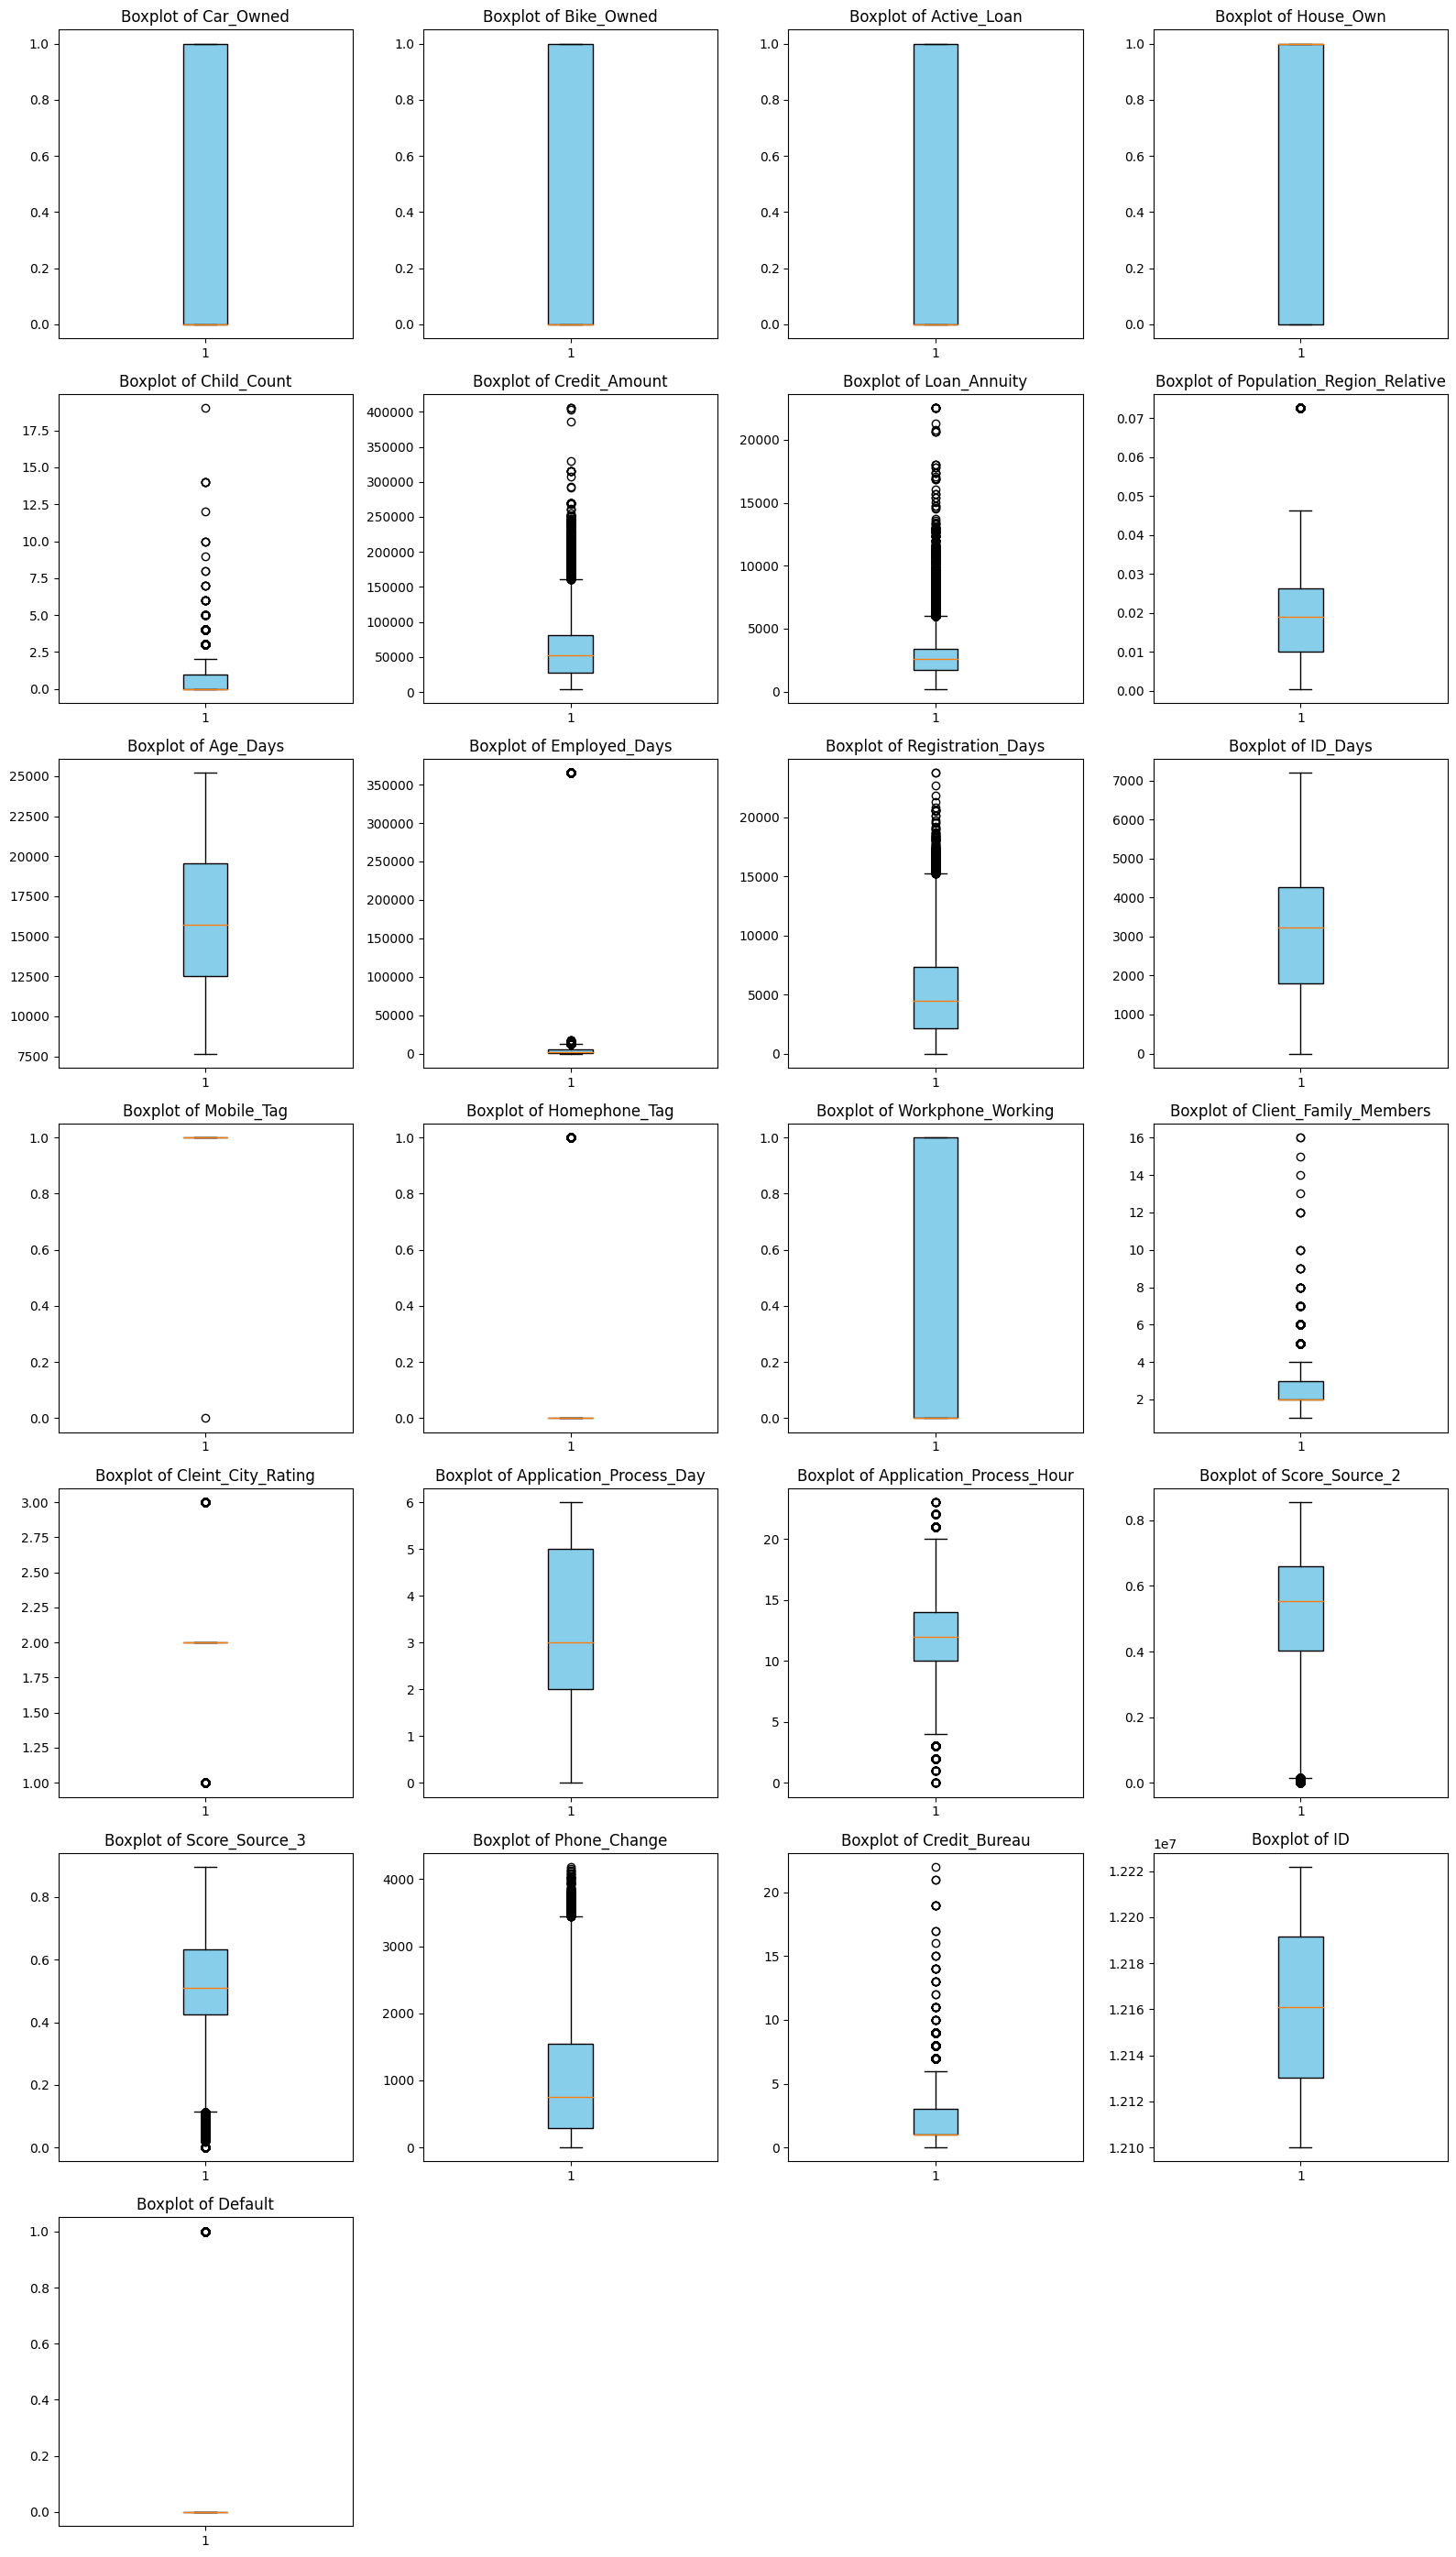

In [25]:
# Identify numeric columns
numeric_cols = data.select_dtypes(include=['number']).columns[1:]  # Exclude 'ID' column
numeric_data = data[numeric_cols]  # Subset numeric data

# Set up the grid layout for multiple boxplots
num_cols = len(numeric_cols)
rows = (num_cols // 4) + (num_cols % 4 > 0)  # Arrange in 4 columns

plt.figure(figsize=(16, rows * 4))  # Adjust figure size dynamically

# Plot boxplots for each numeric variable
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 4, i)  # Define subplot grid
    plt.boxplot(numeric_data[col].dropna(), patch_artist=True, boxprops=dict(facecolor="skyblue"))
    plt.title(f"Boxplot of {col}")

plt.tight_layout()  # Adjust layout for better visualization
plt.show()

In [26]:
def treat_outliers_iqr(df, column):
    """
    Treat outliers in a specified column using the IQR method.
    Values outside the range [Q1 - 1.5*IQR, Q3 + 1.5*IQR] are capped.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        column (str): The column name to treat outliers.
    
    Returns:
        pd.Series: The column with outliers capped.
    """
    Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range
    
    # Define lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap outliers
    return df[column].apply(
        lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x
    )

In [27]:
# Columns to treat
columns_to_treat = ["Client_Income", "Credit_Amount", "Child_Count", "Loan_Annuity", "Employed_Days", 
                    "Registration_Days", "Phone_Change", "Score_Source_3"]

# Apply IQR-based outlier treatment
for col in columns_to_treat:
    data[col] = treat_outliers_iqr(data, col)

### Categorical columns cleaning

In [28]:
retain_categories = ['Alone', 'Relative', 'Partner']

# Replace all other categories with 'Other'
data["Accompany_Client"] = data["Accompany_Client"].apply(lambda x: x if x in retain_categories else 'Other')
data['Accompany_Client'].value_counts()

Accompany_Client
Alone       99109
Relative    15741
Partner      4514
Other        2436
Name: count, dtype: int64

In [29]:
retain_categories = ['Service', 'Commercial', 'Retired', 'Govt Job']
    
# Replace all other categories with 'Other'
data["Client_Income_Type"] = data["Client_Income_Type"].apply(lambda x: x if x in retain_categories else 'Other')
data["Client_Income_Type"].value_counts()

Client_Income_Type
Service       64700
Commercial    27751
Retired       21032
Govt Job       8300
Other            17
Name: count, dtype: int64

In [30]:
data["Client_Education"] = data["Client_Education"].replace({'Post Grad': 'Graduation'})
data["Client_Education"].value_counts()

Client_Education
Secondary             87521
Graduation            28867
Graduation dropout     3957
Junior secondary       1455
Name: count, dtype: int64

In [31]:
data["Client_Gender"] = data["Client_Gender"].replace({'XNA': 'Male'})
data["Client_Gender"].value_counts()

Client_Gender
Male      80845
Female    40955
Name: count, dtype: int64

In [32]:
pd.crosstab(data['Type_Organization'], data['Default'])
del data['Type_Organization'] # as it has lot of categories

In [33]:
data['Default'] = data['Default'].replace({'N': 0, 'Y': 1})
data['Default'].value_counts()

Default
0    111959
1      9841
Name: count, dtype: int64

In [36]:
data.shape

(121800, 35)

In [56]:
data.head()

,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Score_Source_2,Score_Source_3,Phone_Change,Credit_Bureau,ID,Default,last_update
0,6750.0,0.0,0.0,1.0,0.0,0.0,61190.550781,3416.850098,Alone,Commercial,Secondary,M,Male,CL,Home,0.028663,13957.0,1062.0,6123.0,383.0,1,1,0,2.0,2.0,6.0,17,Yes,Yes,0.478787,0.511191,63.0,1.0,12142509,0,2025-02-04 21:12:45.339548
1,20250.0,1.0,0.0,1.0,1.0,0.0,15282.000000,1826.550049,Alone,Service,Graduation,M,Male,CL,Home,0.008575,14162.0,4129.0,7833.0,21.0,1,0,1,2.0,2.0,3.0,10,Yes,Yes,0.215068,0.511191,755.0,1.0,12138936,0,2025-02-04 21:12:45.339548
2,18000.0,0.0,0.0,1.0,0.0,1.0,59527.351562,2788.199951,Alone,Service,Graduation dropout,W,Male,CL,Family,0.022800,16790.0,5102.0,4493.0,331.0,1,0,0,2.0,2.0,4.0,12,Yes,Yes,0.552795,0.329655,277.0,0.0,12181264,0,2025-02-04 21:12:45.339548
3,15750.0,0.0,0.0,1.0,1.0,0.0,53870.398438,2295.449951,Alone,Retired,Secondary,M,Male,CL,Home,0.010556,23195.0,12023.0,4493.0,775.0,1,0,0,2.0,3.0,2.0,15,Yes,Yes,0.135182,0.631355,1700.0,3.0,12188929,0,2025-02-04 21:12:45.339548
4,33750.0,1.0,0.0,1.0,0.0,2.0,133988.406250,3547.350098,Alone,Commercial,Secondary,M,Female,CL,Home,0.020713,11366.0,2977.0,5516.0,4043.0,1,0,0,4.0,1.0,3.0,12,Yes,Yes,0.301182,0.355639,674.0,1.0,12133385,0,2025-02-04 21:12:45.339548


In [55]:
data['last_update'] = pd.to_datetime(datetime.now())

In [77]:
# Define SQL Table column order
sql_columns = [
    "ID", "Client_Income", "Car_Owned", "Bike_Owned", "Active_Loan", "House_Own",
    "Child_Count", "Credit_Amount", "Loan_Annuity", "Accompany_Client",
    "Client_Income_Type", "Client_Education", "Client_Marital_Status", "Client_Gender",
    "Loan_Contract_Type", "Client_Housing_Type", "Population_Region_Relative",
    "Age_Days", "Employed_Days", "Registration_Days", "ID_Days", "Own_House_Age",
    "Mobile_Tag", "Homephone_Tag", "Workphone_Working", "Client_Occupation",
    "Client_Family_Members", "Cleint_City_Rating", "Application_Process_Day",
    "Application_Process_Hour", "Client_Permanent_Match_Tag", "Client_Contact_Work_Tag",
    "Type_Organization", "Score_Source_1", "Score_Source_2", "Score_Source_3",
    "Social_Circle_Default", "Phone_Change", "Credit_Bureau", "last_update"
]

In [78]:
df_cleaned = data.copy(deep=True)
df_cleaned.shape

(121800, 36)

In [79]:
# Add missing columns with NULL values
for col in sql_columns:
    if col not in df_cleaned.columns:
        df_cleaned[col] = None  # Add column with NULL values

In [80]:
del df_cleaned['Default']

In [81]:
df_cleaned = df_cleaned[sql_columns]

In [82]:
df_cleaned.head()

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,Client_Income_Type,Client_Education,Client_Marital_Status,Client_Gender,Loan_Contract_Type,Client_Housing_Type,Population_Region_Relative,Age_Days,Employed_Days,Registration_Days,ID_Days,Own_House_Age,Mobile_Tag,Homephone_Tag,Workphone_Working,Client_Occupation,Client_Family_Members,Cleint_City_Rating,Application_Process_Day,Application_Process_Hour,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,last_update
0,12142509,6750.0,0.0,0.0,1.0,0.0,0.0,61190.550781,3416.850098,Alone,Commercial,Secondary,M,Male,CL,Home,0.028663,13957.0,1062.0,6123.0,383.0,None,1,1,0,None,2.0,2.0,6.0,17,Yes,Yes,None,None,0.478787,0.511191,None,63.0,1.0,2025-02-04 21:12:45.339548
1,12138936,20250.0,1.0,0.0,1.0,1.0,0.0,15282.000000,1826.550049,Alone,Service,Graduation,M,Male,CL,Home,0.008575,14162.0,4129.0,7833.0,21.0,None,1,0,1,None,2.0,2.0,3.0,10,Yes,Yes,None,None,0.215068,0.511191,None,755.0,1.0,2025-02-04 21:12:45.339548
2,12181264,18000.0,0.0,0.0,1.0,0.0,1.0,59527.351562,2788.199951,Alone,Service,Graduation dropout,W,Male,CL,Family,0.022800,16790.0,5102.0,4493.0,331.0,None,1,0,0,None,2.0,2.0,4.0,12,Yes,Yes,None,None,0.552795,0.329655,None,277.0,0.0,2025-02-04 21:12:45.339548
3,12188929,15750.0,0.0,0.0,1.0,1.0,0.0,53870.398438,2295.449951,Alone,Retired,Secondary,M,Male,CL,Home,0.010556,23195.0,12023.0,4493.0,775.0,None,1,0,0,None,2.0,3.0,2.0,15,Yes,Yes,None,None,0.135182,0.631355,None,1700.0,3.0,2025-02-04 21:12:45.339548
4,12133385,33750.0,1.0,0.0,1.0,0.0,2.0,133988.406250,3547.350098,Alone,Commercial,Secondary,M,Female,CL,Home,0.020713,11366.0,2977.0,5516.0,4043.0,None,1,0,0,None,4.0,1.0,3.0,12,Yes,Yes,None,None,0.301182,0.355639,None,674.0,1.0,2025-02-04 21:12:45.339548


In [73]:
df_cleaned.head

In [83]:
from sqlalchemy import create_engine

In [85]:
# ✅ Use SQLAlchemy for Pandas `.to_sql()`
engine = create_engine(f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server")


In [87]:
# Insert DataFrame into SQL Server table
# df_cleaned.to_sql('Silver.silver_customers', con= engine, schema='Silver', if_exists='append', index=False, chunksize=500)